# Advanced Lane Lines

In this project we will revisit the lane line detection project using some more advanced computer vision techniques.

In [2]:
# Import packages.
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration

Before we begin detecting lane lines, we will need to calibrate the camera. This will allow us to correct for distortions in the images taken by the camera.

Camera distortion will be determined by looking for corners in a chessboard image taken from various angles. Loop through each of these calibration images to construct a mapping from image coordinates to real world coordinates.

In [3]:
# Prepare object points.
nx = 9 # The number of horizontal inside corners.
ny = 6 # The number of vertical inside corners.

# Arrays to store detected image points and object points.
objpoints = [] # 3D points in real world space.
imgpoints = [] # 2D points in image space.

# Prepare the object points. These will be the same for all images.
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Loop through the calibration images/
nb_images = 0
nb_detected = 0
for filename in os.listdir('camera_cal'):
    nb_images += 1
    # Load the calibration image.
    img = cv2.imread('camera_cal/' + filename)
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        nb_detected += 1
        # Add object points and image points.
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw detected corners on the image.
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    # Save the images, with corners annotated if found.
    cv2.imwrite('output_images/corners-' + filename, img)

# Print results of corner detection.
print('Successfully found corners in {} of {} calibration images.'.format(nb_detected, nb_images))

Successfully found corners in 17 of 20 calibration images.


## Distortion Correction

Now that the mappings from image space to the real world have been collected, we can use OpenCV to calculate the camer matrix and distortion coefficients. We can verify these values by undistorting the calibration images.

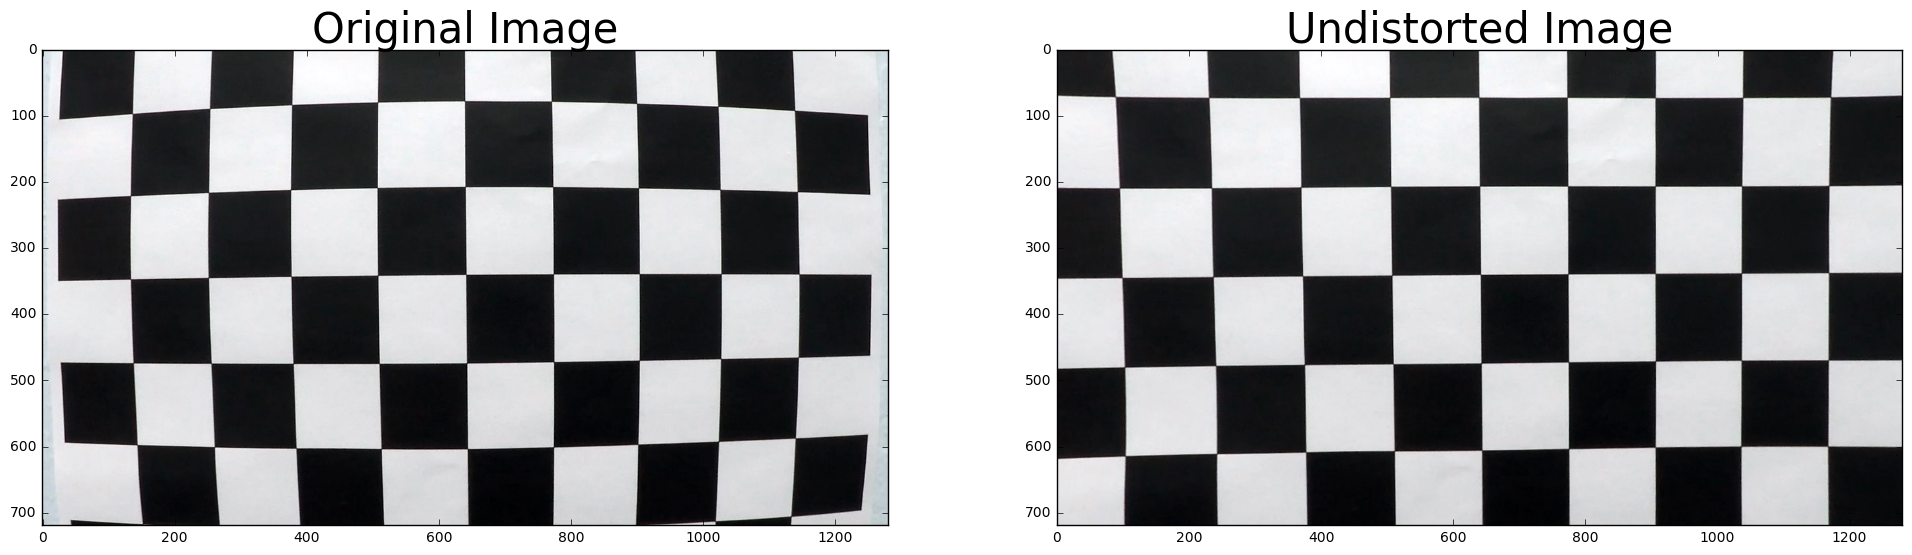

In [4]:
# Get the shape of the calibration images.
img = cv2.imread('camera_cal/calibration1.jpg')
shape = img.shape[0:2]

# Calculate the camera matrix and distortion coefficients.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)  

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

# Plot the original and undistorted images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Loop through the calibration images.
for filename in os.listdir('camera_cal'):
    # Load the calibration image.
    img = cv2.imread('camera_cal/' + filename)
    # Undistort the image.
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # Save the undistorted images.
    cv2.imwrite('output_images/undistorted-' + filename, img)

## Color/Gradient Thresholds

With distortion correction now solved, we can move on to work more directly with finding lanes. The next step will be to apply some mixture of color and gradient thresholding to identify points that likely belong to the lane line.

### HLS Saturation Thresholds

The BGR color representation that OpenCV uses natively to process images does not lend itself well to lane detection. Instead, we will convert the images into an alternative color space that is more robust to road conditions. In particular, the saturation channel of the HSL color space has shown itself to be particularly good at identifying both white and yellow lane lines under various lighting conditions.

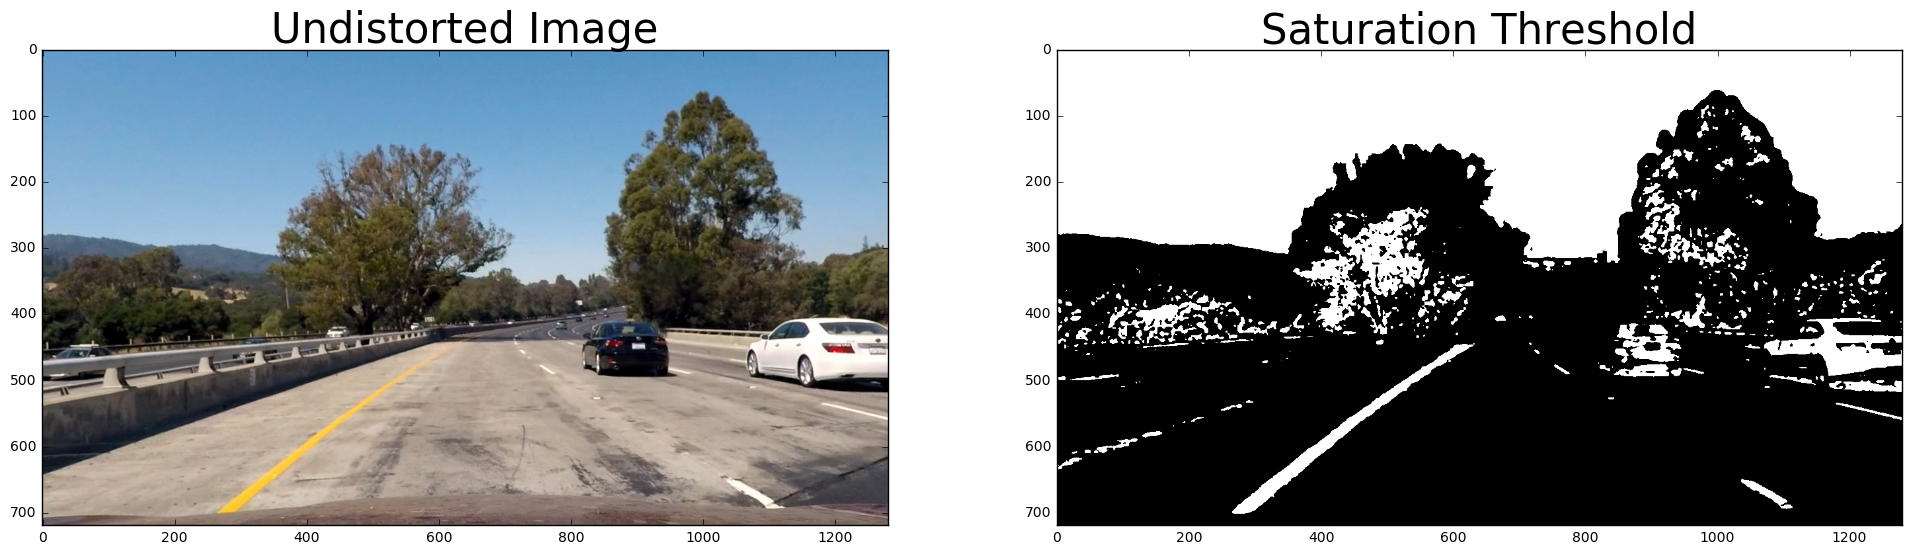

In [201]:
SATURATION_THRESHOLD = (90, 255)

def saturation_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    s = cv2.GaussianBlur(s, (5, 5), 0)
    binary = np.zeros_like(s)
    binary[(s > SATURATION_THRESHOLD[0]) & (s <= SATURATION_THRESHOLD[1])] = 1
    return binary

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = saturation_threshold(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Saturation Threshold', fontsize=30)

Thresholding on the saturation channel in the HLS colorspace has done a good job of isolating both the yellow and white lane lines, but it has worked better in some of the test images than others.

In [202]:
# Loop through the test images and apply the saturation threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = saturation_threshold(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/saturation-threshold-' + filename, img)

### Sobel Gradient Thresholds

In the first version of this project, we used Canny edge detection to isolate lanes lines. This worked well, but the algorithm found edges in both the horizontal and vertical directions. Since lane lines are mostly vertical, it would be better to emphasize the vertical edges. This is possible through the use of Sobel filters.

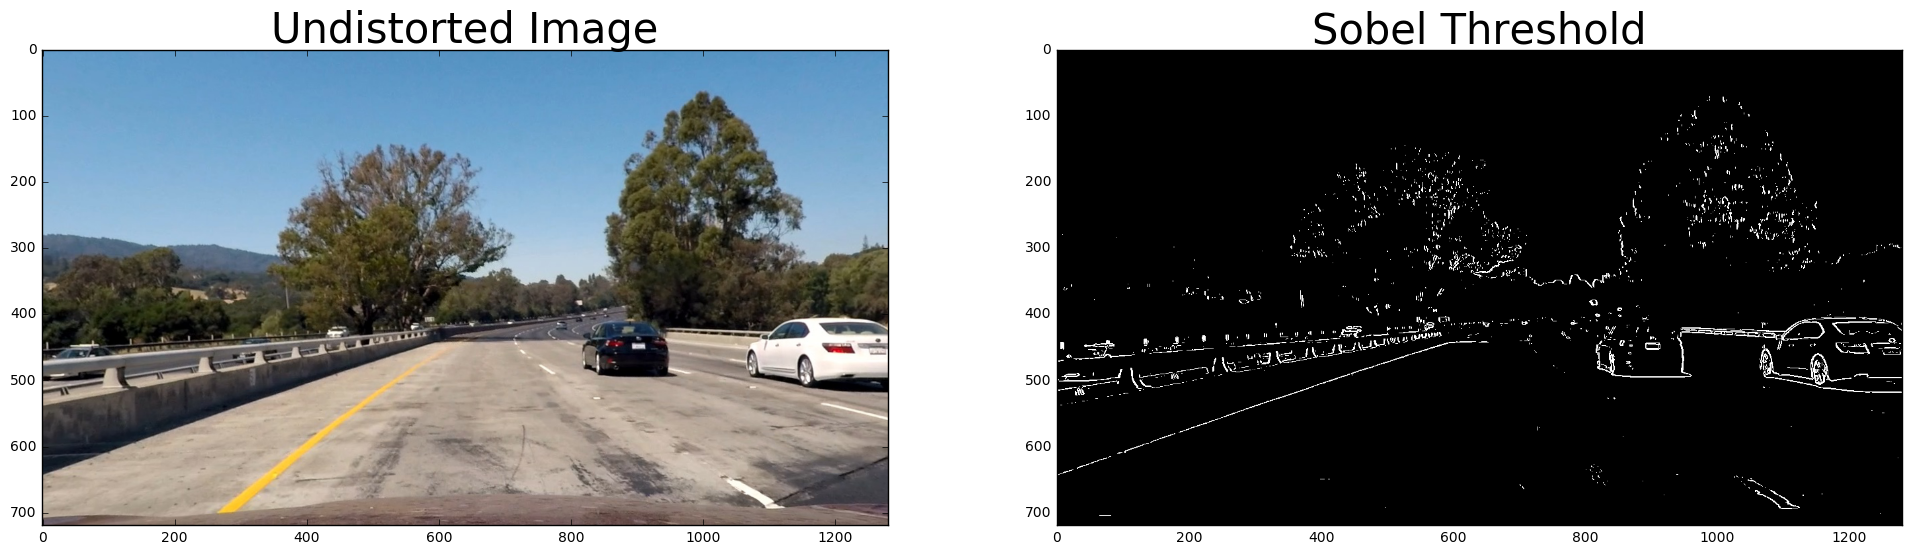

In [203]:
SOBEL_X_THRESHOLD = (50, 200)
SOBEL_Y_THRESHOLD = (100, 200)

def sobel_threshold(img, dir='x', thresh=SOBEL_X_THRESHOLD):
    if dir == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255. * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combined_sobel(img):
    # Convert the image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Sobel thresholds.
    sobel_x = sobel_threshold(gray, 'x', SOBEL_X_THRESHOLD)
    sobel_y = sobel_threshold(gray, 'y', SOBEL_Y_THRESHOLD)
    # Combine the filters.
    binary = np.zeros_like(sobel_x)
    binary[(sobel_x == 1) | (sobel_y == 1)] = 1
    return binary

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = combined_sobel(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Sobel Threshold', fontsize=30)

In [194]:
# Loop through the test images and apply the sobel threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_sobel(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/combined-sobel-' + filename, img)

The Sobel threshold filter didn't work as well with the washed out lines in this image as the color saturation filter, but it did work better on other test images.

### Combined Thresholds

The saturation and sobel filters each performed differently based on various conditions of the images. Rather than relying on one or the other, we can combine the filters to produce a thresholding function that takes advantages of the unique properties of each.

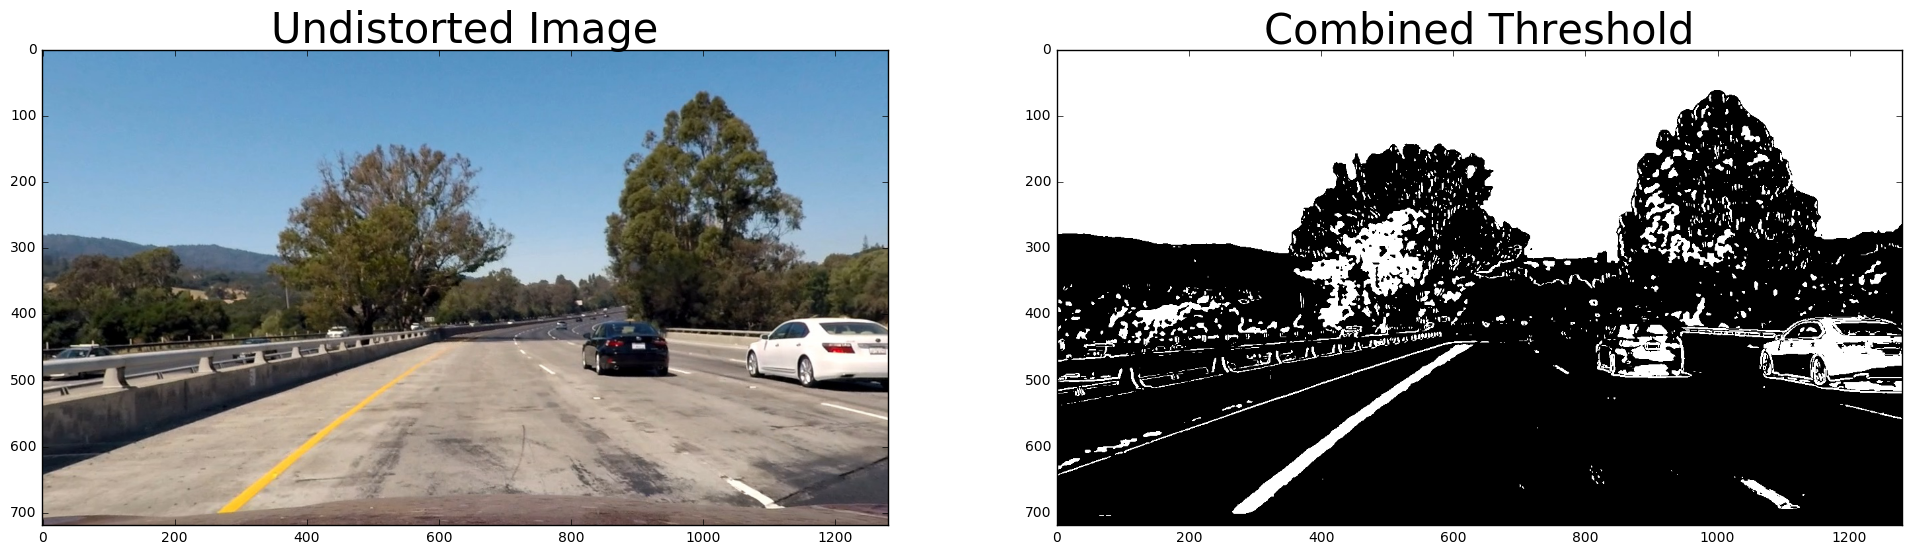

In [205]:
def combined_threshold(img):
    img = cv2.GaussianBlur(img,(5, 5), 0)
    saturation_binary = saturation_threshold(img)
    sobel_binary = combined_sobel(img)
    combined = np.zeros_like(saturation_binary)
    combined[(saturation_binary == 1) | (sobel_binary == 1)] = 1
    return combined

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = combined_threshold(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=30)

By combining color based and gradient based thresholding techniques, we were able to isolate lane lines in images where neither technique alone would have been sufficient. While we could continue to try different types and combinations of thresholds, using just these two will give us a good start.

In [206]:
# Loop through the test images amd apply the combined threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_threshold(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/combined-threshold-' + filename, img)

## Perspective Transform

To simplify the detection of lane lines as well as to compute the radius of curvature, we will create a perspective transform that will warp the images so that they appear as if we were looking at them from above.

The test images all feature various degrees of curving roads, which makes it hard to identify points that can be used to define the transform. Instead of using the provided test images, we scanned through the project video to find a relatively straight section of road to identify source points for the transform. This new image has been saved to the ```test_images``` directory as ```straight.jpg```.

As an implementation detail, the order of operation is reversed here and the thresholding operations are performed after the perspective transform. This was found to provide better results for the final warped image.

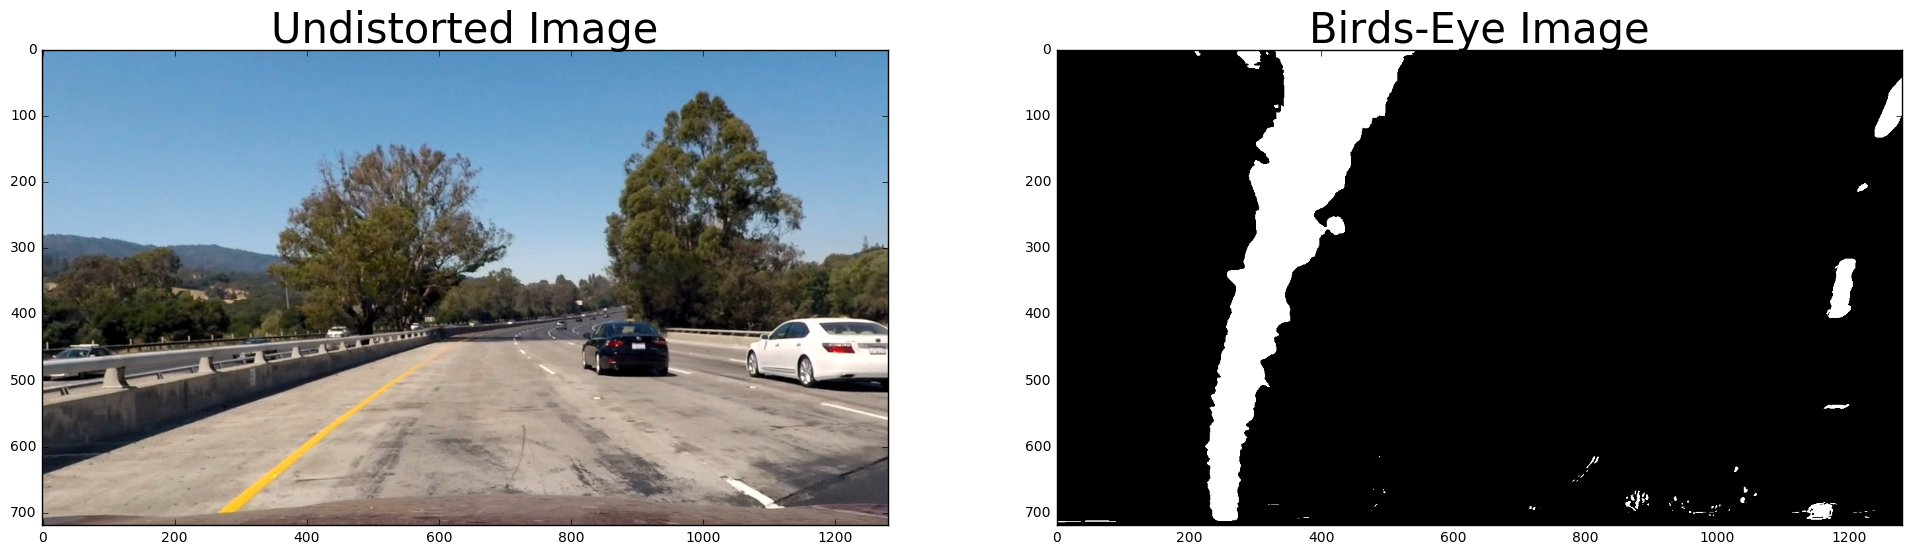

In [207]:
#PERSPECTIVE_SRC_POINTS = np.float32([[265, 695], [495, 520], [830, 520], [1135, 695]])
#PERSPECTIVE_DST_POINTS = np.float32([[265, 695], [265, 520], [1135, 520], [1135, 695]])
PERSPECTIVE_SRC_POINTS = np.float32([[250, 719], [500, 520], [825, 520], [1180, 719]])
PERSPECTIVE_DST_POINTS = np.float32([[250, 719], [250, 520], [1180, 520], [1180, 719]])
M = cv2.getPerspectiveTransform(PERSPECTIVE_SRC_POINTS, PERSPECTIVE_DST_POINTS)
Minv = cv2.getPerspectiveTransform(PERSPECTIVE_DST_POINTS, PERSPECTIVE_SRC_POINTS)

def warp(img):
    image_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)

def unwarp(img):
    image_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, Minv, image_size, flags=cv2.INTER_LINEAR)

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = warp(img)
dst = combined_threshold(dst)

# Plot the original and warped images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Birds-Eye Image', fontsize=30)

In [208]:
# Loop through the test images amd apply the perspective transform.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = warp(img)
    img = combined_threshold(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/warp-' + filename, img)

## Finding Lane Lines

### Histogram

To first detect a starting point for the lane lines, we will create a histogram of possible points in the lower half of the warped image. The points in the lower half of the screen haven't been as distorted by the transform to the birds-eye view and are more likely to be closer to vertical, which will help keep the width of the histogram peaks small and better localized.

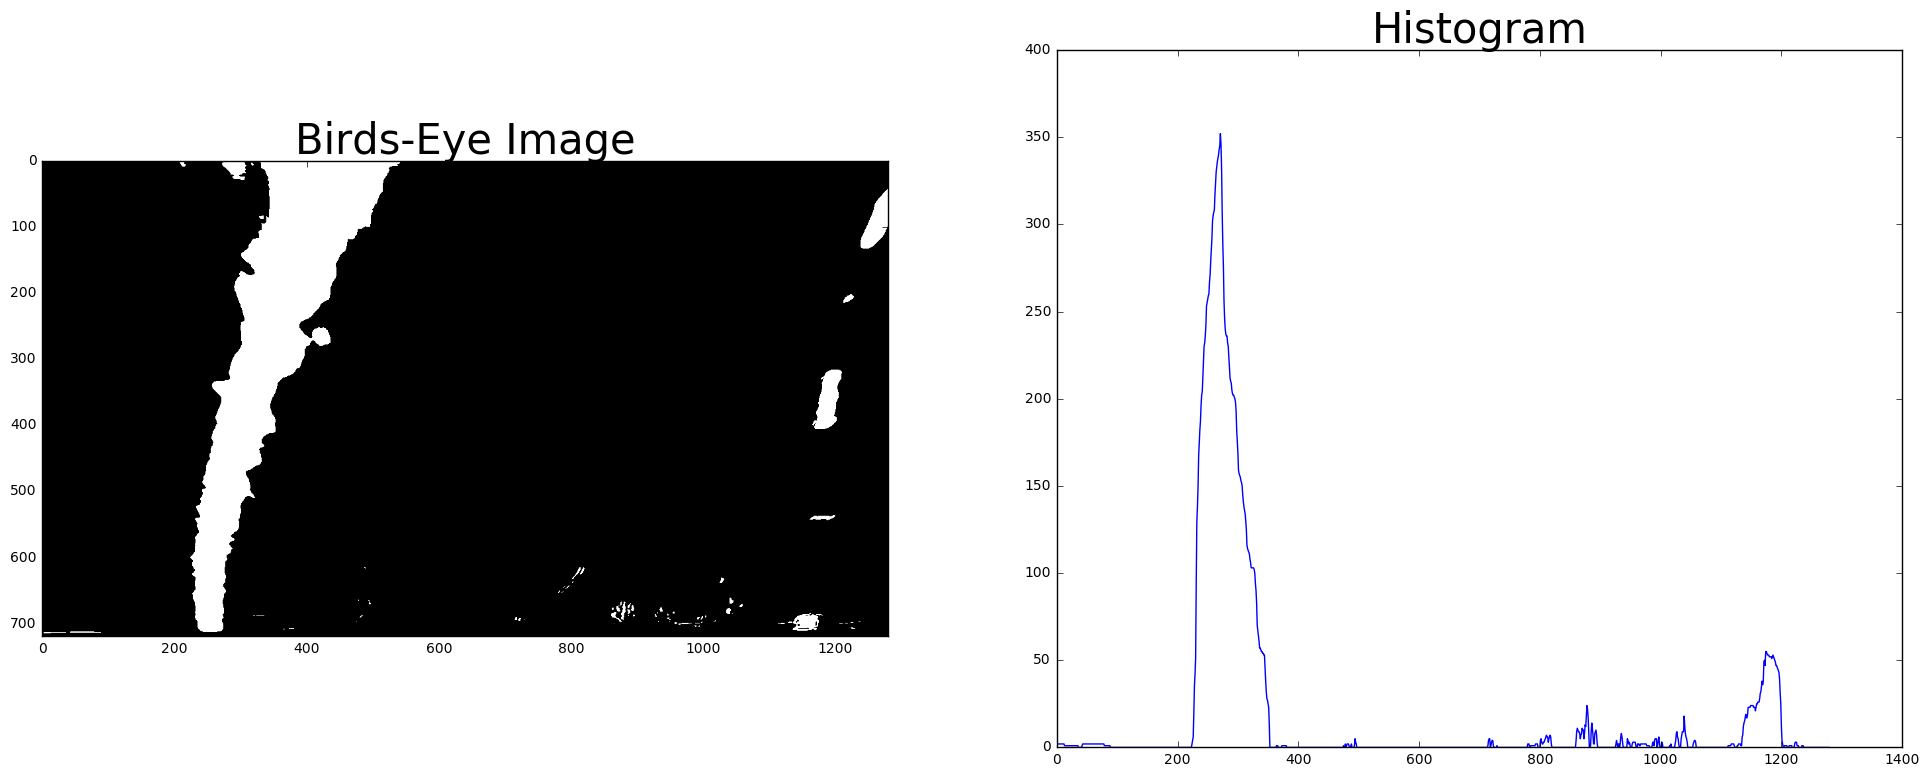

In [209]:
def histogram(img):
    return np.sum(img[img.shape[0]/2:,:], axis=0)

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
img = warp(img)
img = combined_threshold(img)
hist = histogram(img)

# Plot the original and histogram images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img, cmap='gray')
ax1.set_title('Birds-Eye Image', fontsize=30)
ax2.plot(hist)
ax2.set_title('Histogram', fontsize=30)

In [210]:
# Loop through the test images amd apply the perspective transform.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = warp(img)
    img = combined_threshold(img)
    hist = histogram(img)
    plt.title('Histogram')
    plt.plot(hist)
    plt.savefig('output_images/histogram-' + filename, bbox_inches='tight')
    plt.close()

### Detecting Lane Lines

We have now applied all of the thresholding, transformations, and histograms and are ready to try to detect the lane lines. We will use a utility class to track the progress of the detection of each lane and pass that information along to help speed up detection in subsequent frames.

In [211]:
# Dimensions of sliding window to search for lane points.
SLIDING_WINDOW_WIDTH = 150
SLIDING_WINDOW_HEIGHT = 90

# Conversion of pixels to meters, as given in the lecture notes.
X_METERS_PER_PIXEL = 1 # 3.7 / 700.
Y_METERS_PER_PIXEL = 1 #30. / 720.

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def detect_lane(img, line, xmin, xmax):
    if not line.detected:
        # If we haven't found a lane line yet, start with the peak
        # of the histogram as the best guess.
        hist = histogram(img)
        xstart = xmin + np.argmax(hist[xmin:xmax])
    
    # Process sliding windows of points.
    xleft = xstart - SLIDING_WINDOW_WIDTH // 2
    ybottom = img.shape[0]
    allx = []
    ally = []
    while ybottom > 0:
        # clip the sliding window start to the bounds of the image.
        xleft = min(max(0, xleft), img.shape[1])
        xright = min(xleft + SLIDING_WINDOW_WIDTH, img.shape[1])
        ytop = max(0, ybottom - SLIDING_WINDOW_HEIGHT)

        # Loop through every pixel in the sliding window to see if
        # it should be added to the candidate line.
        xvalues = []
        for y in range(ytop, ybottom):
            for x in range(xleft, xright):
                if img[y][x] > 0:
                    xvalues.append(x)
                    allx.append(x)
                    ally.append(y)
        
        # Move the sliding window up and recenter it on the mean
        # x value of the detected points.
        ybottom -= SLIDING_WINDOW_HEIGHT
        if len(xvalues) > 0:
            xleft = int(np.mean(xvalues) - SLIDING_WINDOW_WIDTH // 2)
    
    # Check to see if we detected at least a reasonable number of candidate
    # points for the line.
    if len(allx) < 20:
        line.allx = None
        line.ally = None
        line.radius_of_curvature = None
    else:
        # Calculate coefficients and radius of curve fit to detected points.
        allx = np.array(allx)
        ally = np.array(ally)
        coeffs = np.polyfit(ally*Y_METERS_PER_PIXEL, allx*X_METERS_PER_PIXEL, 2)
        # evaluate radius at bottom of image.
        y_eval = img.shape[0]
        radius = ((1 + (2*coeffs[0]*y_eval + coeffs[1])**2)**1.5)/np.absolute(2*coeffs[0])
        
        # Save line parameters.
        line.allx = allx
        line.ally = ally
        line.current_fit = coeffs
        line.radius_of_curvature = radius

def detect_lanes(img, left_line, right_line):
    # Find the center point of the image. For now we will assume that the
    # car won't change lanes so that we can look for the left lane in the
    # left half of the image and the right lane in the right half.
    detect_lane(img, left_line, 0, img.shape[1] // 2 - 1)
    detect_lane(img, right_line, img.shape[1] // 2, img.shape[1] - 1)

### Draw the Lane Mask

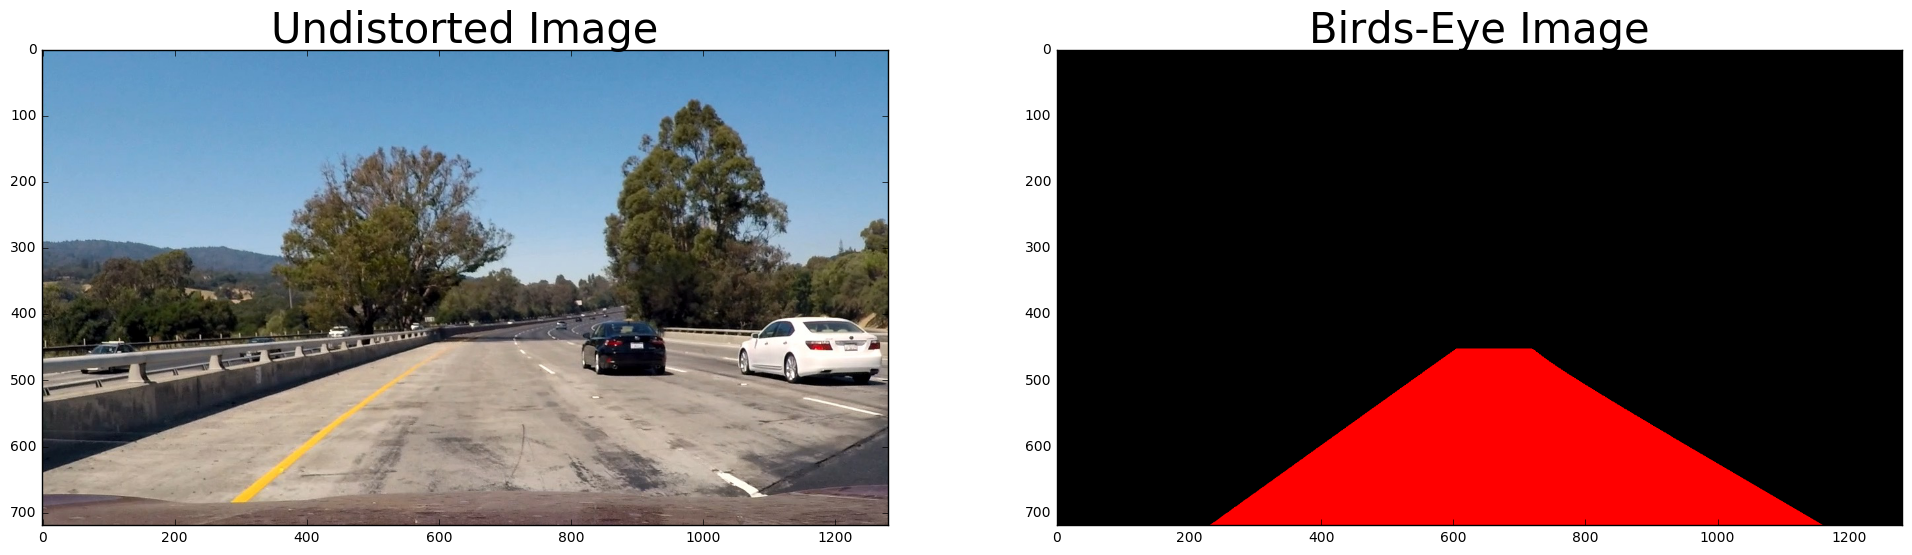

In [216]:
def fit_point(y, line):
    return int(line.current_fit[2] + line.current_fit[1]*y + line.current_fit[0]*y*y)

def draw_mask(img, left_line, right_line):
    channel_zeros = np.zeros_like(img).astype(np.uint8)
    mask = np.dstack((channel_zeros, channel_zeros, channel_zeros))
    for y in range(img.shape[0]):
        xleft = fit_point(y, left_line)
        xright = fit_point(y, right_line)
        cv2.line(mask, (xleft, y), (xright, y), (255, 0, 0))
    return mask

img1 = cv2.imread('test_images/test1.jpg')
img = undistort(img1)
img = warp(img)
img = combined_threshold(img)

left_line = Line()
right_line = Line()
detect_lanes(img, left_line, right_line)
mask = draw_mask(img, left_line, right_line)

# Plot the original and warped images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(unwarp(mask))
ax2.set_title('Birds-Eye Image', fontsize=30)

## Image Processing Pipeline

The image processing pipeline will form the basis of the lane lines detection. The pipeline will combine all of the steps developed above to process a single image or frame of video.

In [217]:
def pipeline(img, left_line, right_line):
    # Undistort the image to correct for camera distortions.
    img = undistort(img)
    # Warp the perspective to a birds-eye view 
    warped = warp(img)
    # Apply thresholds to isolate potential lane line points.
    thresh = combined_threshold(warped)
    # Detect the lane lines
    detect_lanes(thresh, left_line, right_line)
    # Draw the lane mask.
    warped_mask = draw_mask(thresh, left_line, right_line)
    # Unwarp the lane maske
    mask = unwarp(warped_mask)
    # Combine the original image with the lane mask.
    combined = cv2.addWeighted(img, 0.8, mask, 1., 0.)
    
    # Return the processed image.
    return combined

In [218]:
# Loop through the test images and apply the pipeline.
for filename in os.listdir('test_images'):
    if filename.startswith('test'):
        img = cv2.imread('test_images/' + filename)
        left_line = Line()
        right_line = Line()
        img = pipeline(img, left_line, right_line)
        cv2.imwrite('output_images/pipeline-' + filename, img)

## Video Pipeline

In [219]:
def process_image():
    left_line = Line()
    right_line = Line()
    return (lambda img: pipeline(img, left_line, right_line))

for filename in ['project_video.mp4', 'challenge_video.mp4', 'harder_challenge_video.mp4']:
    clip = VideoFileClip(filename)
    out = clip.fl_image(process_image())
    out.write_videofile('processed-' + filename, audio=False)
    

[MoviePy] >>>> Building video processed-project_video.mp4
[MoviePy] Writing video processed-project_video.mp4


100%|█████████▉| 1260/1261 [08:35<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-project_video.mp4 

[MoviePy] >>>> Building video processed-challenge_video.mp4
[MoviePy] Writing video processed-challenge_video.mp4


100%|██████████| 485/485 [12:27<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-challenge_video.mp4 

[MoviePy] >>>> Building video processed-harder_challenge_video.mp4
[MoviePy] Writing video processed-harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [08:33<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-harder_challenge_video.mp4 

